Scanning: /workspace/obsidian/Zettelkasten
Found 1067 valid notes. Processing with 4 cores...



--- Top Cluster Identifiers ---
Cluster 0: book author, author book, peak performance, affiliate marketing, philip zimbardo, change life, sales marketing, booker washington, marketing lead, information marketer
Cluster 1: customer avatar, avatar buyer, buyer persona, people reference, capture details, useful customer, persona capture, details real, reference related, content vault
Cluster 2: united states, map content, city martinsville, fb facebook, henry county, wikipedia wiki, en wikipedia, soil health, cash flow, dan kennedy
Cluster 3: social media, knowledge workers, lead generation, real estate, time management, subject matter, target audience, high ticket, search engine, knowledge worker
Cluster 4: martinsville va, va 24112, national bank, ridgeway va, millions dollars, various ways, masonic lodge, farmview dr, 30 years, city martinsville
Cluster 5: critical thinking, climate change, mental health, executive function, better sleep, decision making, difficult people, long term, 

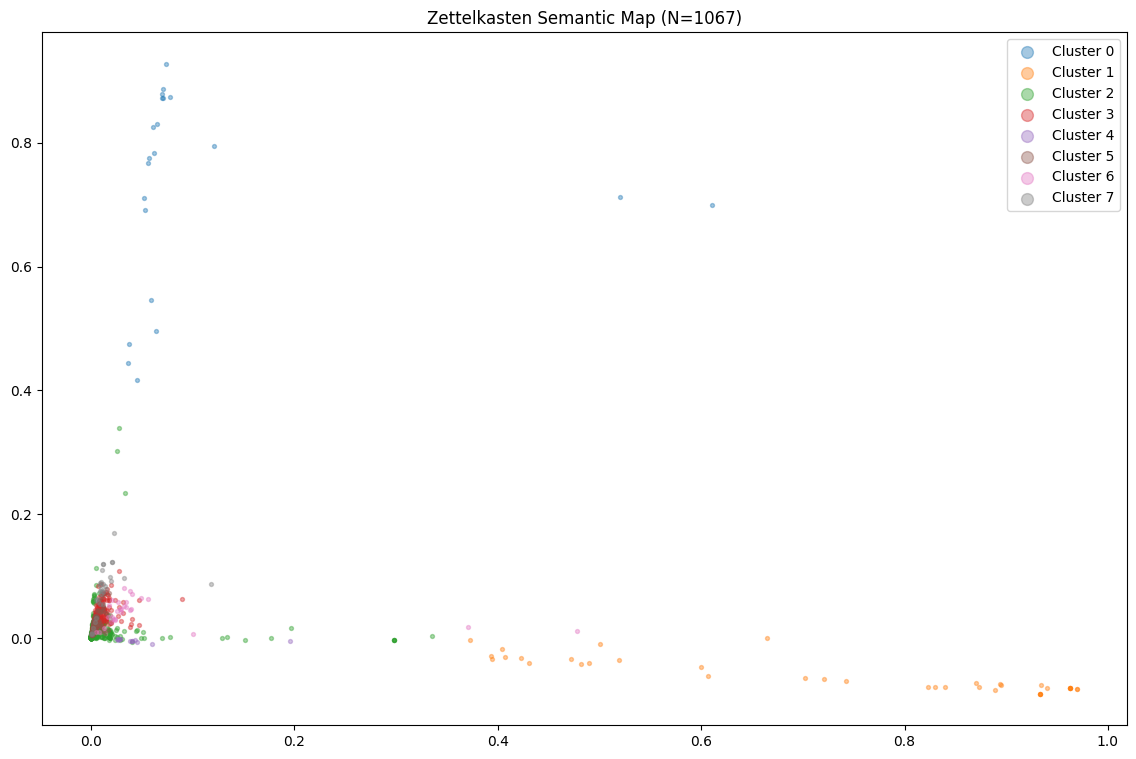

In [15]:
import os
import re
import sys
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

# --- Tuning & Hyperparameters ---
N_CLUSTERS = 8           
TAG_WEIGHT = 5           
MAX_FEATURES = 5000      
NGRAM_RANGE = (2, 2)     
MIN_DOC_FREQ = 5         

CUSTOM_STOP_WORDS = {
    'https', 'http', 'com', 'www', 'org', 'net', 'html', 'eof', 
    'g_face', 'q_auto', 'image', 'png', 'jpg', 'figure', 'ref'
}

# --- Performance & Disk Filtering ---
ZETTEL_ROOT = "/workspace/obsidian/Zettelkasten" 
DIRECTORY_EXCLUSIONS = {"Templates", "node_modules", "Archive"} # Non-dot folders to skip
FILE_EXCLUSIONS = ["TEMPLATE"] 

# --- Processing Functions ---

def split_camel_case(text):
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

def is_date_pattern(text):
    text_str = str(text).strip()
    return bool(re.match(r'^\d{4}(-\d{2}(-\d{2})?)?$|^\d{8}', text_str))

def clean_headers(text):
    lines = text.split('\n')
    filtered_lines = []
    for line in lines:
        if line.lstrip().startswith('#'):
            header_content = re.sub(r'^#+\s*', '', line).strip()
            if len(header_content.split()) > 2:
                filtered_lines.append(header_content)
        else:
            filtered_lines.append(line)
    return '\n'.join(filtered_lines)

def extract_note_data(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
    except Exception:
        return None

    # 1. YAML Tags
    yaml_tags = []
    yaml_match = re.search(r'^---\s*\n(.*?)\n---\s*\n', content, re.DOTALL)
    if yaml_match:
        try:
            meta = yaml.safe_load(yaml_match.group(1))
            if meta and 'tags' in meta:
                raw_tags = meta['tags']
                if isinstance(raw_tags, list):
                    yaml_tags = [str(t) for t in raw_tags if t is not None and not is_date_pattern(t)]
                elif raw_tags is not None and not is_date_pattern(raw_tags):
                    yaml_tags = [str(raw_tags)]
        except: pass

    # 2. Hashtags
    hashtag_raw = re.findall(r'#([A-Z][a-z]+(?:[A-Z][a-z]+)+)', content)
    hashtag_split = [split_camel_case(ht) for ht in hashtag_raw if not is_date_pattern(ht)]
    
    # 3. Body (Stripping Frontmatter and Cleaning Headers)
    body = re.sub(r'^---\s*\n(.*?)\n---\s*\n', '', content, flags=re.DOTALL)
    body = clean_headers(body)
    body = re.sub(r'\d{4}-\d{2}-\d{2}|\d{4}-\d{2}|\d{8}', '', body)
    
    meta_str = (" ".join(yaml_tags) + " " + " ".join(hashtag_split) + " ") * TAG_WEIGHT
    return {'name': filepath.name, 'text': (meta_str + body).strip()}

def main():
    print(f"Scanning: {ZETTEL_ROOT}")
    
    # --- Dynamic Path Filtering ---
    filtered_paths = []
    # rglob captures all .md files, but we filter them immediately
    for p in Path(ZETTEL_ROOT).rglob('*.[mM][dD]'):
        # 1. Ignore if ANY part of the path starts with a dot (e.g. .obsidian/config.md)
        # 2. Ignore if the filename itself starts with a dot (e.g. .temp_note.md)
        if any(part.startswith('.') for part in p.parts):
            continue
            
        # 3. Ignore explicit non-dot directories (e.g. Templates)
        if any(part in DIRECTORY_EXCLUSIONS for part in p.parts):
            continue
            
        # 4. Ignore Template filenames
        if any(excl.upper() in p.name.upper() for excl in FILE_EXCLUSIONS):
            continue
            
        filtered_paths.append(p)

    print(f"Found {len(filtered_paths)} valid notes. Processing with {multiprocessing.cpu_count()} cores...")
    
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(extract_note_data, filtered_paths))

    df = pd.DataFrame([r for r in results if r is not None])
    if df.empty:
        print("No valid markdown files found after filtering.")
        return

    # --- Vectorization & ML ---
    all_stops = list(ENGLISH_STOP_WORDS.union(CUSTOM_STOP_WORDS))
    vectorizer = TfidfVectorizer(
        stop_words=all_stops,
        ngram_range=NGRAM_RANGE, 
        max_features=MAX_FEATURES,
        min_df=MIN_DOC_FREQ
    )

    X = vectorizer.fit_transform(df['text'])
    model = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
    df['cluster'] = model.fit_predict(X)

    # Use SVD to avoid dense-matrix memory errors with 32k files
    svd = TruncatedSVD(n_components=2, random_state=42)
    coords = svd.fit_transform(X)
    df['x'], df['y'] = coords[:, 0], coords[:, 1]

    # --- Analysis Output ---
    terms = vectorizer.get_feature_names_out()
    centroids = model.cluster_centers_.argsort()[:, ::-1]

    print("\n--- Top Cluster Identifiers ---")
    for i in range(N_CLUSTERS):
        top_terms = [terms[ind] for ind in centroids[i, :10]]
        print(f"Cluster {i}: {', '.join(top_terms)}")

    # --- Plotting ---
    plt.figure(figsize=(14, 9))
    for i in range(N_CLUSTERS):
        sub = df[df['cluster'] == i]
        plt.scatter(sub['x'], sub['y'], label=f"Cluster {i}", alpha=0.4, s=8)
    
    plt.title(f"Zettelkasten Semantic Map (N={len(df)})")
    plt.legend(markerscale=3)
    plt.show()

if __name__ == "__main__":
    main()

    